In [ ]:
# Install regression library
!pip install piecewise-regression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sp
import piecewise_regression
import statsmodels.api as sm
from google.colab import files
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Upload CSV file containing storage anomaly time series with gaps. This file should have two columns with the first column = dates, and second column = data.

from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  uploaded_file_name = fn
  print(f'User uploaded file "{fn}"')

Saving base_file.csv to base_file.csv
User uploaded file "base_file.csv"


In [ ]:
# Copy contents of CSV file to a dataframe
grace_df = pd.read_csv(uploaded_file_name, index_col=0)
grace_df.index = pd.to_datetime(grace_df.index)
grace_df.index = grace_df.index.to_series().dt.strftime("%Y-%m")
grace_df.index = pd.to_datetime(grace_df.index)

In [ ]:
# Plot the time series.
dates = pd.date_range(grace_df.index[0], grace_df.index[len(grace_df.index)-1], freq='MS')
column_name = grace_df.columns.to_list()[0]

df1 = pd.DataFrame(np.nan, index=dates, columns=[column_name])
df1.index.name = 'Date'
grace_df_total = df1.fillna(grace_df)

total_series = go.Scatter(name='Groundwater Storage (Calculated)', x=grace_df_total.index, y=grace_df_total.iloc[:, 0].values)
plot_series = [total_series]
layout = go.Layout(title="Groundwater Storage (Calculated)", xaxis=dict(title='Date',), yaxis=dict(title='Groundwater Storage (Calculated)',),)
chart_obj = go.Figure(data=plot_series, layout=layout)
chart_obj.show()

In [ ]:
# Process initial trends and seasonality
grace_df_des = sm.tsa.seasonal_decompose(grace_df, model='additive', period=12)

grace_df_res_trend = grace_df_des.trend.copy()
grace_df_res_seasonal = grace_df_des.seasonal.copy()
grace_df_res_resid = grace_df_des.resid.copy()

grace_df_res_trend = grace_df_res_trend.dropna()
grace_df_res_seasonal = grace_df_res_seasonal.dropna()
grace_df_res_resid = grace_df_res_resid.dropna()

grace_df_res_trend_index = grace_df_res_trend.index.to_list()
grace_df_res_trend_index = np.array(grace_df_res_trend_index, dtype=np.datetime64)
grace_df_res_trend_index = np.array(grace_df_res_trend_index, dtype=np.timedelta64)
grace_df_res_trend_index = np.array(grace_df_res_trend_index, dtype=np.long)

grace_df_res_trend_index_dates = []
for date in grace_df_res_trend_index:
    grace_df_res_trend_index_dates.append(dt.datetime.fromtimestamp(date/1000000))

grace_df_res_trend = grace_df_res_trend.to_frame()
grace_df_res_seasonal = grace_df_res_seasonal.to_frame()
grace_df_res_resid = grace_df_res_resid.to_frame()

In [ ]:
# Compute a linear regression and adjust seasonality components

slope, intercept, r_value, p_value, std_err = sp.linregress(grace_df_res_trend_index, grace_df_res_trend.iloc[:, 0].values)

df2 = pd.DataFrame(np.nan, index=dates, columns=['trend'])
df2.index.name = 'Date'
grace_df_res_trend_total = df2.fillna(grace_df_res_trend)

df3 = pd.DataFrame(np.nan, index=dates, columns=['seasonal'])
df3.index.name = 'Date'
grace_df_res_seasonal_total = df3.fillna(grace_df_res_seasonal)

df4 = pd.DataFrame(np.nan, index=dates, columns=['resid'])
df4.index.name = 'Date'
grace_df_res_resid_total = df4.fillna(grace_df_res_resid)

In [ ]:
# Plot the original data and the trend curve with a single linear regression for context

fig = make_subplots(rows=2, cols=1, subplot_titles=("Orignal GWSA", "Trend"))

fig.add_trace(go.Scatter(
                x=grace_df_total.index,
                y=grace_df_total.iloc[:, 0].values,
                name='Groundwater Storage (Calculated)',),
              row=1, col=1)

fig.add_trace(go.Scatter(
    x=grace_df_res_trend_index_dates,
    y=grace_df_res_trend.iloc[:, 0].values,
    mode='markers',
    name='',
    line=dict(color='blue'),),
    row=2, col=1)

fig.add_trace(go.Scatter(
                x=grace_df_res_trend_total.index,
                y=grace_df_res_trend_total.iloc[:, 0].values,
                name='Trend',),
              row=2, col=1)

fig.add_trace(go.Scatter(
    x=[dt.datetime.fromtimestamp(grace_df_res_trend_index[0]/1000000), dt.datetime.fromtimestamp(grace_df_res_trend_index[-1]/1000000)],
    y=[slope * grace_df_res_trend_index[0] + intercept, slope * grace_df_res_trend_index[-1] + intercept],
    mode='lines',
    name='{0}x + {1}'.format(str(round(slope, 2)), str(round(intercept, 2))),
    line=dict(color='black', dash='dash'),),
    row=2, col=1)

fig.update_layout(showlegend=False)
chart_obj = go.Figure(fig)
chart_obj.show()

In [ ]:
# At this point you should examine the trend curve to see if it has multiple linear sections. If so, the imputation
# can give better results if we split the time domain into multiple segments and process each separately. To do
# this we will use some code that does an optimal piecewise linear regression. To start this process, select
# a number of breakpoints. For example, if you see 3 linear sections, use 2 breakpoints. You may need to iterate
# this section of cells until you get a result that looks good. 
# NOTE: Make sure that each segment has at least 24 months or seasonality will not be defined.

number_breakpoints = 3

In [ ]:
# Get the required data to define the different trends
data_index = np.array(grace_df.index, dtype=np.datetime64)
data_index = np.array(data_index, dtype=np.timedelta64)
data_index = np.array(data_index, dtype=np.long)
x=data_index
y=np.array(grace_df[column_name])

In [ ]:
# Perform the piecewise regression and view a summary of the results
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=number_breakpoints)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                      199
No. Model Parameters                    8
Degrees of Freedom                    191
Res. Sum of Squares                3448.9
Total Sum of Squares              14376.2
R Squared                        0.760095
Adjusted R Squared               0.749994
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const           -3.32477e-33     2.29e-34      -14.528      1.06e-32  -3.7762e-33  -2.8734e-33
alpha1          -1.94425e-18     4.11e-19      -4.7313      4.33e-06  -2.7548e-18  -1.1337e-18
beta1            2.07875e-16     1.12e-17       18.531             -   1.8575e-16      2.3e-16
beta2           -2.92431e-16        2e-17      -14.642             -  -3.3183e-16  -2.5304e-16
beta3            

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                      199\nNo. Model Parameters                    8\nDegrees of Freedom                    191\nRes. Sum of Squares                3448.9\nTotal Sum of Squares              14376.2\nR Squared                        0.760095\nAdjusted R Squared               0.749994\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst           -3.32477e-33     2.29e-34      -14.528      1.06e-32  -3.7762e

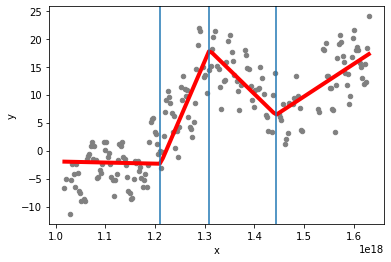

In [ ]:
# Plot the data, fit, breakpoints and confidence intervals.
# If this looks good, continue. Otherwise, select a new number of breakpoints and repeat.
pw_fit.plot_data(color="grey", s=20)
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [ ]:
# Get the breakpoints from the multi-regression results and split into a set of ranges
# num_ranges = num_breakpoints + 1
pw_results = pw_fit.get_results()
pw_estimates = pw_results["estimates"]

alpha_array = []
beta_array = []
breakpoints_array = []

for i in range(number_breakpoints+1):
  if i < number_breakpoints:
    alpha_array.append(pw_estimates["alpha{}".format(str(i+1))]["estimate"])
    beta_array.append(pw_estimates["beta{}".format(str(i+1))]["estimate"])
    breakpoints_array.append(pw_estimates["breakpoint{}".format(str(i+1))]["estimate"])
  else:
    alpha_array.append(pw_estimates["alpha{}".format(str(i+1))]["estimate"])

breakpoints_dates_array = []
for date in breakpoints_array:
  breakpoints_dates_array.append(dt.datetime.fromtimestamp(date/1000000000))

In [ ]:
for i in range(number_breakpoints):
  if i == 0:
    globals()['grace_df_subset_{}'.format(i+1)] = grace_df.loc[grace_df.index < pd.to_datetime(breakpoints_dates_array[i])]
  else:
    globals()['grace_df_subset_{}'.format(i+1)] = grace_df.loc[grace_df.index < pd.to_datetime(breakpoints_dates_array[i])]
    globals()['grace_df_subset_{}'.format(i+1)] = globals()['grace_df_subset_{}'.format(i+1)].loc[globals()['grace_df_subset_{}'.format(i+1)].index > pd.to_datetime(breakpoints_dates_array[i-1])]

globals()['grace_df_subset_{}'.format(i+2)] = grace_df.loc[grace_df.index > pd.to_datetime(breakpoints_dates_array[i])]

In [ ]:
# Decompose each of the subsets
for i in range(number_breakpoints + 1):
  if len(globals()['grace_df_subset_{}'.format(i+1)].index) >= 24:
    globals()['grace_df_res_{}'.format(i+1)] = sm.tsa.seasonal_decompose(globals()['grace_df_subset_{}'.format(i+1)], model='additive', period=12)
    globals()['grace_df_res_trend_{}'.format(i+1)] = globals()['grace_df_res_{}'.format(i+1)].trend.copy()
    globals()['grace_df_res_seasonal_{}'.format(i+1)] = globals()['grace_df_res_{}'.format(i+1)].seasonal.copy()
    globals()['grace_df_res_resid_{}'.format(i+1)] = globals()['grace_df_res_{}'.format(i+1)].resid.copy()
    globals()['grace_df_res_trend_{}'.format(i+1)] = globals()['grace_df_res_trend_{}'.format(i+1)].to_frame()
    globals()['grace_df_res_seasonal_{}'.format(i+1)] = globals()['grace_df_res_seasonal_{}'.format(i+1)].to_frame()
    globals()['grace_df_res_resid_{}'.format(i+1)] = globals()['grace_df_res_resid_{}'.format(i+1)].to_frame()
  else:
    periodo = math. trunc(len(globals()['grace_df_subset_{}'.format(i+1)].index)/2)
    globals()['grace_df_res_{}'.format(i+1)] = sm.tsa.seasonal_decompose(globals()['grace_df_subset_{}'.format(i+1)], model='additive', period=periodo)
    globals()['grace_df_res_trend_{}'.format(i+1)] = globals()['grace_df_res_{}'.format(i+1)].trend.copy()
    globals()['grace_df_res_seasonal_{}'.format(i+1)] = globals()['grace_df_res_{}'.format(i+1)].seasonal.copy()
    globals()['grace_df_res_resid_{}'.format(i+1)] = globals()['grace_df_res_{}'.format(i+1)].resid.copy()
    globals()['grace_df_res_trend_{}'.format(i+1)] = globals()['grace_df_res_trend_{}'.format(i+1)].to_frame()
    globals()['grace_df_res_seasonal_{}'.format(i+1)] = globals()['grace_df_res_seasonal_{}'.format(i+1)].to_frame()
    globals()['grace_df_res_resid_{}'.format(i+1)] = globals()['grace_df_res_resid_{}'.format(i+1)].to_frame()

In [ ]:
# Adjust linear regressions and export files of components
for i in range(number_breakpoints+1):
  globals()['grace_df_res_trend_{}'.format(i+1)] = globals()['grace_df_res_trend_{}'.format(i+1)].dropna()
  globals()['grace_df_res_trend_index_{}'.format(i+1)] = globals()['grace_df_res_trend_{}'.format(i+1)].index.to_list()
  globals()['grace_df_res_trend_index_{}'.format(i+1)] = np.array(globals()['grace_df_res_trend_index_{}'.format(i+1)], dtype=np.datetime64)
  globals()['grace_df_res_trend_index_{}'.format(i+1)] = np.array(globals()['grace_df_res_trend_index_{}'.format(i+1)], dtype=np.timedelta64)
  globals()['grace_df_res_trend_index_{}'.format(i+1)] = np.array(globals()['grace_df_res_trend_index_{}'.format(i+1)], dtype=np.long)

  globals()['grace_df_res_trend_index_dates_{}'.format(i+1)] = []
  for date in globals()['grace_df_res_trend_index_{}'.format(i+1)]:
    globals()['grace_df_res_trend_index_dates_{}'.format(i+1)].append(dt.datetime.fromtimestamp(date/1000000))
  
  globals()['slope_{}'.format(i+1)], globals()['intercept_{}'.format(i+1)],globals()['r_value_{}'.format(i+1)], globals()['p_value_{}'.format(i+1)], globals()['std_err_{}'.format(i+1)] = sp.linregress(globals()['grace_df_res_trend_index_{}'.format(i+1)], globals()['grace_df_res_trend_{}'.format(i+1)].iloc[:, 0].values)

  if i == number_breakpoints:
    globals()['dates_{}'.format(i+1)] = pd.date_range(globals()['grace_df_subset_{}'.format(i+1)].index[0], globals()['grace_df_subset_{}'.format(i+1)].index[len(globals()['grace_df_subset_{}'.format(i+1)].index)-1], freq='MS')
  else:
    globals()['dates_{}'.format(i+1)] = pd.date_range(globals()['grace_df_subset_{}'.format(i+1)].index[0], globals()['grace_df_subset_{}'.format(i+2)].index[0], freq='MS')
    globals()['dates_{}'.format(i+1)] = globals()['dates_{}'.format(i+1)][:-1]
  
  globals()['df1_{}'.format(i+1)] = pd.DataFrame(np.nan, index=globals()['dates_{}'.format(i+1)], columns=[column_name])
  globals()['df1_{}'.format(i+1)].index.name = 'Date'
  globals()['grace_df_subset_total_{}'.format(i+1)] = globals()['df1_{}'.format(i+1)].fillna(globals()['grace_df_subset_{}'.format(i+1)])

  globals()['df2_{}'.format(i+1)] = pd.DataFrame(np.nan, index=globals()['dates_{}'.format(i+1)], columns=['trend'])
  globals()['df2_{}'.format(i+1)].index.name = 'Date'
  globals()['grace_df_res_trend_total_{}'.format(i+1)] = globals()['df2_{}'.format(i+1)].fillna(globals()['grace_df_res_trend_{}'.format(i+1)])

  globals()['df3_{}'.format(i+1)] = pd.DataFrame(np.nan, index=dates, columns=['seasonal'])
  globals()['df3_{}'.format(i+1)].index.name = 'Date'
  globals()['grace_df_res_seasonal_total_{}'.format(i+1)] = globals()['df3_{}'.format(i+1)].fillna(globals()['grace_df_res_seasonal_{}'.format(i+1)])

  globals()['df4_{}'.format(i+1)] = pd.DataFrame(np.nan, index=dates, columns=['resid'])
  globals()['df4_{}'.format(i+1)].index.name = 'Date'
  globals()['grace_df_res_resid_total_{}'.format(i+1)] = globals()['df4_{}'.format(i+1)].fillna(globals()['grace_df_res_resid_{}'.format(i+1)])

In [ ]:
# Plot the results after processing each range independently.

fig = make_subplots(rows=4, cols=1, subplot_titles=("Orignal GWSA", "Trend", "Seasonality", "Resid"))

fig.add_trace(go.Scatter(
    x=grace_df_total.index,
    y=grace_df_total.iloc[:, 0].values,
    mode='lines',
    name='Groundwater Storage (Calculated)',
    line=dict(color='#636EFA'),),
    row=1, col=1)

for i in range(number_breakpoints+1):

  fig.add_trace(go.Scatter(
      x=globals()['grace_df_subset_total_{}'.format(i+1)].index,
      y=globals()['grace_df_subset_total_{}'.format(i+1)].iloc[:, 0].values,
      mode='lines',
      name='Groundwater Storage (Calculated)',
      line=dict(color='#636EFA'),),
      row=1, col=1)
  
  fig.add_trace(go.Scatter(
      x=globals()['grace_df_res_trend_index_dates_{}'.format(i+1)],
      y=globals()['grace_df_res_trend_{}'.format(i+1)].iloc[:, 0].values,
      mode='markers',
      name='',
      line=dict(color='blue'),),
      row=2, col=1)
  
  fig.add_trace(go.Scatter(
      x=globals()['grace_df_res_trend_total_{}'.format(i+1)].index,
      y=globals()['grace_df_res_trend_total_{}'.format(i+1)].iloc[:, 0].values,
      mode='lines',
      name='Trend',
      line=dict(color='#00CC96'),),
      row=2, col=1)
  
  fig.add_trace(go.Scatter(
      x=[dt.datetime.fromtimestamp(globals()['grace_df_res_trend_index_{}'.format(i+1)][0]/1000000), dt.datetime.fromtimestamp(globals()['grace_df_res_trend_index_{}'.format(i+1)][-1]/1000000)],
      y=[globals()['slope_{}'.format(i+1)] * globals()['grace_df_res_trend_index_{}'.format(i+1)][0] + globals()['intercept_{}'.format(i+1)], globals()['slope_{}'.format(i+1)] * globals()['grace_df_res_trend_index_{}'.format(i+1)][-1] + globals()['intercept_{}'.format(i+1)]],
      mode='lines',
      name='{0}x + {1}'.format(str(round(globals()['slope_{}'.format(i+1)], 2)), str(round(globals()['intercept_{}'.format(i+1)], 2))),
      line=dict(color='black', dash='dash'),),
      row=2, col=1)
  
  fig.add_trace(go.Scatter(
      x=globals()['grace_df_res_seasonal_total_{}'.format(i+1)].index,
      y=globals()['grace_df_res_seasonal_total_{}'.format(i+1)].iloc[:, 0].values,
      mode='lines',
      name='Seasonality',
      line=dict(color='#FFA15A'),),
      row=3, col=1)
  
  fig.add_trace(go.Scatter(
      x=globals()['grace_df_res_resid_total_{}'.format(i+1)].index,
      y=globals()['grace_df_res_resid_total_{}'.format(i+1)].iloc[:, 0].values,
      mode='lines',
      name='Resid',
      line=dict(color='#19D3F3'),),
      row=4, col=1)

fig.update_layout(showlegend=False)

chart_obj = go.Figure(fig)

chart_obj.show()

In [ ]:
# Combine the components to fill in missing data

grace_df_res_seasonal_total.rename(columns={'seasonal':column_name}, inplace=True)
grace_df_res_resid_total.rename(columns={'resid':column_name}, inplace=True)

seasonal_df = grace_df_res_seasonal_total + grace_df_res_resid_total
seasonal_df.dropna(inplace=True)

seasonal_mean_df = seasonal_df.groupby(seasonal_df.index.strftime("%m"))
seasonal_mean_df = seasonal_mean_df.mean()

grace_df_total_v2 = grace_df_total.copy()

for i in range(number_breakpoints+1):
  globals()['grace_df_res_seasonal_total_{}'.format(i+1)].rename(columns={'seasonal':column_name}, inplace=True)
  globals()['grace_df_res_resid_total_{}'.format(i+1)].rename(columns={'resid':column_name}, inplace=True)

  globals()['seasonal_df_{}'.format(i+1)] = globals()['grace_df_res_seasonal_total_{}'.format(i+1)] + globals()['grace_df_res_resid_total_{}'.format(i+1)]
  globals()['seasonal_df_{}'.format(i+1)].dropna(inplace=True)

  globals()['seasonal_mean_df_{}'.format(i+1)] = globals()['seasonal_df_{}'.format(i+1)].groupby(globals()['seasonal_df_{}'.format(i+1)].index.strftime("%m"))
  globals()['seasonal_mean_df_{}'.format(i+1)] = globals()['seasonal_mean_df_{}'.format(i+1)].mean()

  a = np.full((1, len(globals()['seasonal_mean_df_{}'.format(i+1)].index)), False, dtype=bool)

  globals()['seasonal_mean_{}'.format(i+1)] = globals()['grace_df_res_seasonal_total_{}'.format(i+1)].groupby(globals()['grace_df_res_seasonal_total_{}'.format(i+1)].index.strftime("%m"))
  globals()['seasonal_mean_{}'.format(i+1)] = globals()['seasonal_mean_{}'.format(i+1)].mean()
  globals()['seasonal_mean_{}'.format(i+1)].dropna(inplace=True)

  b = np.full((1, len(globals()['seasonal_mean_{}'.format(i+1)].index)), False, dtype=bool)

  indexes = list(range(0, len(globals()['grace_df_subset_total_{}'.format(i+1)].index)))

  globals()['grace_df_subset_completed_{}'.format(i+1)] = globals()['grace_df_subset_total_{}'.format(i+1)].copy()

  for date, j in zip(globals()['dates_{}'.format(i+1)], indexes):
    if np.isnan(globals()['grace_df_subset_total_{}'.format(i+1)].loc[globals()['grace_df_subset_total_{}'.format(i+1)].index == date].values[0][0]):
      mes = globals()['grace_df_subset_total_{}'.format(i+1)].index[j].month
      if mes < 10:
        mes = '0'+str(mes)
      else:
        mes = str(mes)
      date_num = np.datetime64(date.to_pydatetime()).astype(np.long)
      c = globals()['seasonal_mean_df_{}'.format(i+1)].index == mes
      if ((c == a[0]).all()):
        d = globals()['seasonal_mean_{}'.format(i+1)].index == mes
        if ((d == b[0]).all()):
          globals()['grace_df_subset_completed_{}'.format(i+1)].loc[globals()['grace_df_subset_completed_{}'.format(i+1)].index == date] = (seasonal_mean_df[seasonal_mean_df.index == mes].values[0][0]) + (globals()['slope_{}'.format(i+1)] * date_num + globals()['intercept_{}'.format(i+1)])
        else:
          globals()['grace_df_subset_completed_{}'.format(i+1)].loc[globals()['grace_df_subset_completed_{}'.format(i+1)].index == date] = (globals()['seasonal_mean_{}'.format(i+1)][globals()['seasonal_mean_{}'.format(i+1)].index == mes].values[0][0]) + (globals()['slope_{}'.format(i+1)] * date_num + globals()['intercept_{}'.format(i+1)])
      else:
        globals()['grace_df_subset_completed_{}'.format(i+1)].loc[globals()['grace_df_subset_completed_{}'.format(i+1)].index == date] = (globals()['seasonal_mean_df_{}'.format(i+1)][globals()['seasonal_mean_df_{}'.format(i+1)].index == mes].values[0][0]) + (globals()['slope_{}'.format(i+1)] * date_num + globals()['intercept_{}'.format(i+1)])
  
  grace_df_total_v2 = grace_df_total_v2.fillna(globals()['grace_df_subset_completed_{}'.format(i+1)])


In [ ]:
# Plot final results

total_series = go.Scatter(name='Orignal GWSA', x=grace_df_total.index, y=grace_df_total.iloc[:, 0].values)
completed_series = go.Scatter(name='Orignal GWSA (Completed)', x=grace_df_total_v2.index, y=grace_df_total_v2.iloc[:, 0].values)

plot_series = [completed_series, total_series]
layout = go.Layout(title="Orignal GWSA (Calculated)", xaxis=dict(title='Date',), yaxis=dict(title='Groundwater Storage',),)
chart_obj = go.Figure(data=plot_series, layout=layout)
chart_obj.show()


In [ ]:
# Export and Download file
grace_df_total_v2.to_csv("completed.csv")
files.download('completed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>